In [60]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 100
import scipy.io.wavfile
from pydub import AudioSegment

In [61]:
import json

data_root = '/NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/'
align = json.load(open('align.json'))

In [62]:
import random

# randomly sample 4 audio files
samples = []
for i in range(4):
    samples.append(random.choice(align[str(i)]))

print(samples)

[['IC0585W0255', 'ong1', 3.13, 0.13], ['IC0018W0122', 'ong2', 2.51, 0.03], ['IC0909W0489', 'ao3', 2.62, 0.12], ['IC0737W0276', 'ao4', 4.73, 0.26]]


In [63]:
def spectro(y, start: float, dur: float, max_dur=0.6, sr=16000, fmin=50, fmax=350, hop_length=16, reverse_y=True, to_db=True):
    from skimage.transform import resize
    
    # make a general bounding box and crop it
    extra_dur = (max_dur - dur) / 2
    bound_s = start - extra_dur
    bound_e = start + dur + extra_dur
    bs, be = librosa.time_to_samples([bound_s, bound_e], sr=sr)
    y = y[bs:be]

    # mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=2048, hop_length=hop_length, fmin=fmin, fmax=fmax)
    if to_db:
        S = librosa.power_to_db(S, ref=np.max)
    if reverse_y:
        S = S[::-1, :]

    # then crop precisely to the start and the end of a phone
    # start = np.max([extra_dur - 0.05, 0])
    # end = np.min([start + dur + 0.05, max_dur])
    start = extra_dur
    end = start + dur
    s, e = librosa.time_to_frames([start, end], sr=sr, hop_length=hop_length)
    s = np.max(s, 0)
    e = np.max(e, 0)
    S[:, :s] = 0
    S[:, e + 1:] = 0

    # resize
    S = resize(
        S, output_shape=(225, 225),
        anti_aliasing=False, preserve_range=True, clip=False,
        mode='constant', cval=0, order=0,
    )
    return S


def plot_spectro(S, cmap='gray', ax=plt):
    ax.imshow(S, cmap=cmap)
    ax.set_axis_off()
    # im = axs[i].imshow(S, cmap='gray')
    # fig.colorbar(im, ax=axs[i])

# Mel-Spectrogram

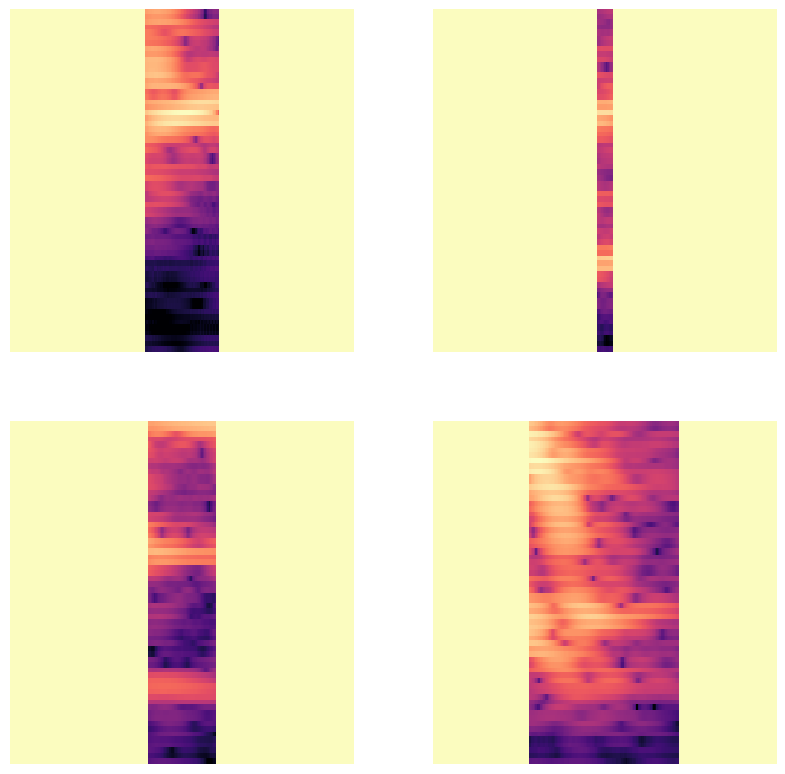

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]
    y, _ = librosa.load(os.path.join(data_root, spk, f'{file}.wav'), sr=16000)
    S = spectro(y, start, dur)
    plot_spectro(S, ax=axs[i], cmap='magma')

# Pitch Tracking

```python
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]
    y, _ = librosa.load(os.path.join(data_root, spk, f'{file}.wav'), sr=16000)
    
    S = spectro(y, start, dur, reverse_y=False, to_db=False)
    pitches, mag = librosa.core.piptrack(S=S, sr=16000)
    axs[i].imshow(pitches, cmap='gray', aspect=1)
```

# Fundamental Frequency

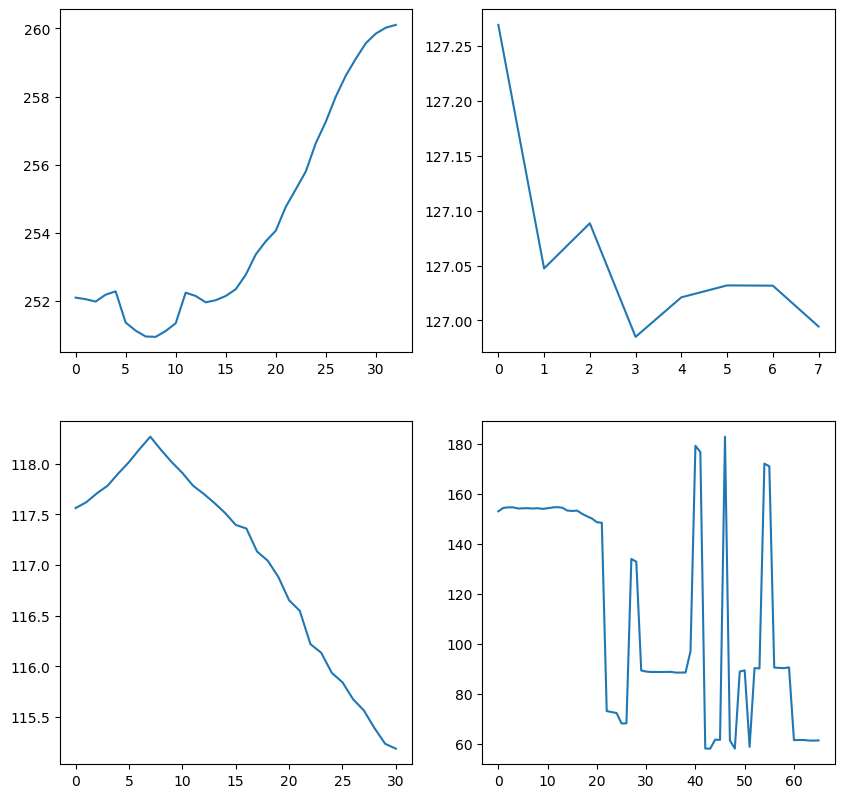

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]
    y, _ = librosa.load(os.path.join(data_root, spk, f'{file}.wav'), sr=16000)

    s, e = librosa.time_to_samples([start, start + dur], sr=16000)
    y = y[s:e]
    f0 = librosa.yin(y, sr=16000, fmin=50, fmax=350, hop_length=64, frame_length=2048)
    axs[i].plot(f0)

# Data Augmentation (add noise)

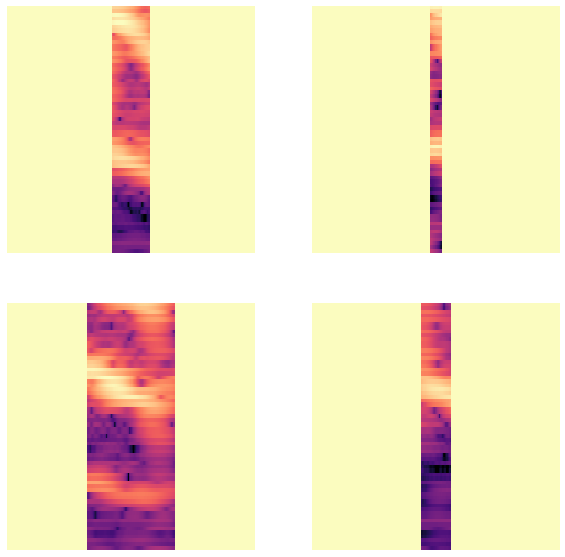

In [6]:
from aug import add_random_noise
import soundfile as sf

f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]
    y, _ = librosa.load(os.path.join(data_root, spk, f'{file}.wav'), sr=16000)
    y = add_random_noise(y, 50)
    # sf.write(f'tmp{i}.wav', y, 16000, 'PCM_16')
    S = spectro(y, start, dur)
    plot_spectro(S, ax=axs[i], cmap='magma')

# Denoise test

In [7]:
# !pip install denoiser

In [8]:
!mkdir -p denoise_test/input
!cp /NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/C0890/IC0890W0094.wav denoise_test/input/
!python -m denoiser.enhance --master64 --noisy_dir=denoise_test/input --out_dir=denoise_test/output

/home/tjy/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
INFO:denoiser.pretrained:Loading pre-trained real time H=64 model trained on DNS and Valentini.
INFO:__main__:Generate enhanced files | 1/1 | 0.5 it/sec


## Original vs. Denoised

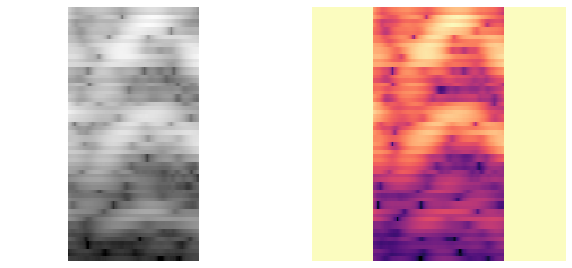

In [9]:
# test file used: ['IC0890W0094', 'u2', 1.49, 0.31]
f, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

start, dur = 1.49, 0.31
y, _ = librosa.load('/NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/C0890/IC0890W0094.wav', sr=16000)
S = spectro(y, start, dur)
plot_spectro(S, ax=axs[0])

y, _ = librosa.load('denoise_test/output/IC0890W0094_enhanced.wav', sr=16000)
S = spectro(y, start, dur)
plot_spectro(S, ax=axs[1], cmap='magma')